# Web Scraping Indeed.co.uk and Predicting Salaries

In [2]:
import pandas as pd

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('bmh')

import seaborn as sns

import requests
import bs4
from bs4 import BeautifulSoup
from pprint import pprint
from tqdm import tqdm

import re

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import statsmodels.formula.api as smf

## Scraping data from indeed.co.uk

Firstly several functions were written to extract the desired data from the scraped html soup having looked at the html of the indeed website.

In [3]:
def extract_location_from_result(soup):
    locations = []
    for job in soup.find_all('div', attrs={'class': 'result'}):
        location = job.find('span', attrs={'class': 'location'})
        if location == None:
            locations.append('None')
        else:
            locations.append(location.text.replace('\n','').strip())
    return locations

In [4]:
def extract_company_from_result(soup):
    companies = []
    for job in soup.find_all('div', attrs={'class': 'result'}):
        company = job.find('span', attrs={'class': 'company'})
        if company == None:
            companies.append('None')
        else:
            companies.append(company.text.replace('\n','').strip())
    return companies

In [5]:
def extract_job_from_result(soup):
    jobs = []
    for job in soup.find_all('div', attrs={'class': 'result'}):
        job_title = job.find('a', attrs={'class': 'turnstileLink'})
        if job_title == None:
            jobs.append('None')
        else:
            jobs.append(job_title.text.replace('\n','').strip())
    return jobs

In [6]:
def extract_salary_from_result(soup):
    salaries = []
    for job in soup.find_all('div', attrs={'class': 'result'}):
        salary = job.find('span', attrs={'class': 'no-wrap'})
        if salary == None:
            salaries.append('None')
        else:
            salaries.append(salary.text.replace('\n','').strip())
    return salaries

In [7]:
def extract_summary_from_result(soup):
    summaries = []
    for job in soup.find_all('div', attrs={'class': 'result'}):
        summary = job.find('span', attrs={'class': 'summary'})
        if summary == None:
            summaries.append('None')
        else:
            summaries.append(summary.text.replace('\n','').strip()) 
    return summaries

The code below was used to scrape the job data. The output of this function was a dictionary of the location(city), company, job title, specific location and the summary description of the jobs on indeed.co.uk. This was done using the above functions.

```python
url_template = 'https://www.indeed.co.uk/jobs?q=data+science&l={}&start={}'
max_results_per_city = 6000

results = {'Location': [],
           'Company': [],
           'Job': [],
           'Specific_location': [],
           'Salary': [],
           'Summary': []}

for city in tqdm(set(['London', 'Edinburgh', 'Newcastle', 'Cambridge', 'Manchester', 
                      'Bristol', 'Liverpool', 'Leeds', 'York', 'Glasgow', 'Sheffield', 
                      'Oxford', 'Cardiff', 'Belfast'])):

    for start in range(0, max_results_per_city, 10):

        r = requests.get(url_template.format(city, start))
        soup = BeautifulSoup(r.text, 'html.parser')

        location = [city.replace(
            '+', ' ') for job in soup.find_all('div', attrs={'class': 'result'})]
        company = extract_company_from_result(soup)
        job = extract_job_from_result(soup)
        specific_location = extract_location_from_result(soup)
        salary = extract_salary_from_result(soup)
        summary = extract_summary_from_result(soup)

        results['Location'].extend(location)
        results['Company'].extend(company)
        results['Job'].extend(job)
        results['Specific_location'].extend(specific_location)
        results['Salary'].extend(salary)
        results['Summary'].extend(summary)
```

In [27]:
# load in the scraped job data
job_data = pd.read_csv('job_data_uk.csv')

## Data cleaning and EDA

In [28]:
job_data.head(5)

,Unnamed: 0,Company,Job,Location,Salary,Specific_location,Summary
0,0,Equifax,Data Scientist,Sheffield,None,Leeds,Function - Data and Analytics. The Data and An...
1,1,Equifax,Junior Big Data Infrastructure Engineer,Sheffield,None,Leeds,Bachelor's degree in Information Science or Co...
2,2,Amazon.com,Solutions Architect Manager - AWS Education - ...,Sheffield,None,Manchester,"Bachelor's degree in computer science, compute..."
3,3,Robert Walters,Data Scientist,Sheffield,None,West Yorkshire,Identifying what internal and external data is...
4,4,HSBC,Data Scientist,Sheffield,None,Sheffield,Data Modelling experience. Strong analytical s...


In [29]:
# remove the 'Unnamed' column automatically created in exporting a csv
job_data = job_data.iloc[:,1:]

In [31]:
# get the info for the DataFrame
job_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128957 entries, 0 to 128956
Data columns (total 6 columns):
Company              128957 non-null object
Job                  128957 non-null object
Location             128957 non-null object
Salary               128957 non-null object
Specific_location    128957 non-null object
Summary              128957 non-null object
dtypes: object(6)
memory usage: 5.9+ MB


The data probably has a lot of duplicates and the head above shows that a lot of jobs have no salary, or a monthly, weekly, daily or hourly salary.

In [32]:
# remove jobs with no salary and drop duplicate jobs
mask = job_data['Salary']!='None'

In [33]:
job_data = job_data.drop_duplicates(
    subset=['Company', 'Job', 'Salary', 'Specific_location', 'Summary']).loc[mask,:].reset_index(drop=True)

In [35]:
job_data.head(5)

,Company,Job,Location,Salary,Specific_location,Summary
0,Home Office,Software Engineering Intern,Sheffield,"£32,867 - £33,229 a year",Sheffield S3,Alternatively have a Computer science or relat...
1,University of Sheffield,Research Associate in One-shot Learning of Hum...,Sheffield,"£30,688 a year",Sheffield,Medicine and the life sciences. Departments in...
2,University of Sheffield,Econometrician Research Associate/Fellow,Sheffield,"£30,688 - £47,722 a year",Sheffield,The analysis of non-randomised data. Post is w...
3,University of Sheffield,Marie Curie Early Stage Researcher in Verifica...,Sheffield,"£31,932 a year",Sheffield,Models that fuse data with physics-based model...
4,DataConsulting,Data Insight Analyst,Sheffield,"£18,000 - £22,000 a year",Wakefield,"Accounting, Computer Science, Business, Financ..."


In [36]:
# only keep jobs with a per year salary
mask = [True if 'year' in job_data.loc[i, 'Salary'] else False for i in range(len(job_data))]

In [37]:
job_data = job_data.loc[mask, :]

A lot of salaries are ranges. These were converted to the mean.

In [21]:
# convert salaries to floats
job_data['Salary'] = [np.mean([float(n) for n in re.findall('\d+', x.replace('£', '')\
                                                            .replace(',', '').replace('- ', '')\
                                                            .replace('a year', '').replace('£', '').strip())]) 
                      for x in job_data['Salary']]

In [40]:
job_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 7 columns):
Unnamed: 0           1015 non-null int64
Company              1015 non-null object
Job                  1015 non-null object
Location             1015 non-null object
Salary               1015 non-null float64
Specific_location    1015 non-null object
Summary              1015 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 55.6+ KB


There are now 1015 job adverts across the UK cities that were scraped on indeed.co.uk.

In [39]:
# load in my pre cleaned data
job_data = pd.read_csv('job_data_final.csv')

## Set classes of low and high salary

Low and high salaries were set .......

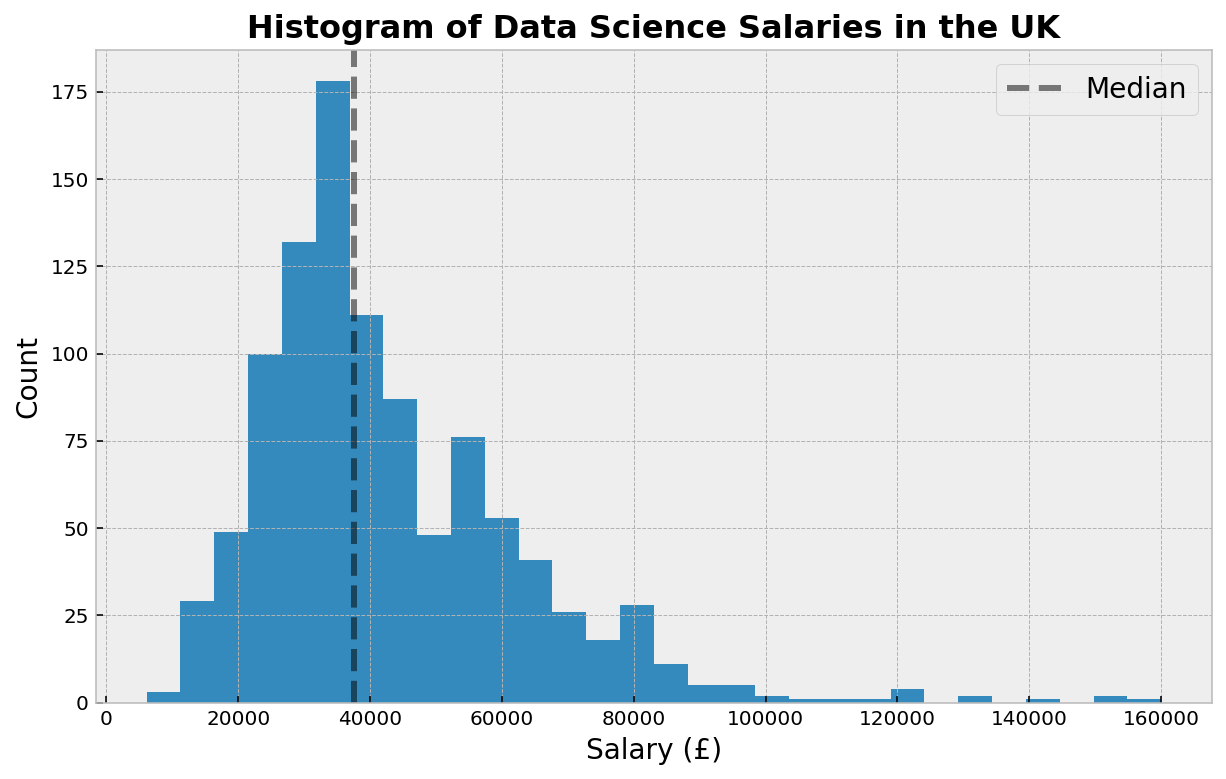

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(job_data['Salary'], bins=30)
ax.axvline(np.median(job_data['Salary']), c='black', alpha=0.5, ls='dashed', lw=3)
ax.legend(['Median'], fontsize=14)
ax.set_xlabel('Salary (£)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Histogram of Data Science Salaries in the UK', fontsize=16, fontweight='bold')
plt.show()

In [28]:
mask = job_data['Salary'] >= np.median(job_data['Salary'])

In [29]:
job_data['salary_high'] = [1 if x==True else 0 for x in mask]

In [30]:
job_data.head()

,Unnamed: 0,Company,Job,Location,Salary,Specific_location,Summary,salary_high
0,0,Home Office,Software Engineering Intern,Sheffield,33048.0,Sheffield S3,Alternatively have a Computer science or relat...,0
1,1,University of Sheffield,Research Associate in One-shot Learning of Hum...,Sheffield,30688.0,Sheffield,Medicine and the life sciences. Departments in...,0
2,2,University of Sheffield,Econometrician Research Associate/Fellow,Sheffield,39205.0,Sheffield,The analysis of non-randomised data. Post is w...,1
3,3,University of Sheffield,Marie Curie Early Stage Researcher in Verifica...,Sheffield,31932.0,Sheffield,Models that fuse data with physics-based model...,0
4,4,DataConsulting,Data Insight Analyst,Sheffield,20000.0,Wakefield,"Accounting, Computer Science, Business, Financ...",0


In [31]:
job_data.groupby(['Location'])[['Job']].count()

,Job
Location,
Belfast,47
Bristol,47
Cambridge,149
Cardiff,66
Edinburgh,41
Glasgow,54
Leeds,11
Liverpool,50
London,205


### Create a classification model to predict High/Low salary. 


**Model based on location:**

- Start by ONLY using the location as a feature. 
- Use logistic regression with both statsmodels and sklearn.
- Use a further classifier you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.

**Model taking into account job levels and categories:**

- Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value? 
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. 
- Discuss model coefficients or feature importances as applicable.

**Model evaluation:**

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 


- Use cross-validation to evaluate your models. 
- Evaluate the accuracy, AUC, precision and recall of the models. 
- Plot the ROC curve for at least one of your models.

**Bonus:**

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC curves for the different models you studied (at least the tuned model of each category) and compare.

#### Model based on location

In [35]:
# dummify location, delete one col --- do some eda on cities, drop highest salary, lowest or absolute middle
# stats models 
# look at evergreen lab for logistic regression using statsmodels --- weeek 4 day 2ish 
# no need to add 1s

In [36]:
y = job_data['salary_high'].copy()
X = job_data['Location'].copy()

In [37]:
X1 = pd.get_dummies(X)

In [38]:
job_data['Salary'].median()

37500.0

In [39]:
job_data.groupby(['Location'])[['Salary']].mean().sort_values('Salary')

,Salary
Location,
Leeds,31068.181818
Sheffield,31403.600000
Newcastle,32808.019231
Cardiff,35306.977273
Liverpool,36267.730000
Bristol,36497.787234
York,36871.517241
Belfast,37197.212766
Glasgow,38029.027778


Will drop Belfast because it is the middle city based on mean salary.

In [40]:
X1.drop(['Belfast'], axis=1, inplace=True)

In [41]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.33, stratify=y, random_state=10)

In [42]:
log_reg = LogisticRegression(solver='liblinear')
log_reg_hyperparams = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-5, 3, 20)
}

In [43]:
log_reg_gs = GridSearchCV(log_reg, log_reg_hyperparams,
                          n_jobs=-1, cv=5, verbose=1)
log_reg_gs.fit(X1_train, y1_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-05, 2.63665e-05, 6.95193e-05, 1.83298e-04, 4.83293e-04,
       1.27427e-03, 3.35982e-03, 8.85867e-03, 2.33572e-02, 6.15848e-02,
       1.62378e-01, 4.28133e-01, 1.12884e+00, 2.97635e+00, 7.84760e+00,
       2.06914e+01, 5.45559e+01, 1.43845e+02, 3.79269e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [44]:
log_reg_gs.best_score_

0.6264705882352941

In [45]:
log_reg_gs.best_params_

{'C': 0.008858667904100823, 'penalty': 'l2'}

In [46]:
log_reg_best = log_reg_gs.best_estimator_

In [47]:
log_reg_best.score(X1_test, y1_test)

0.6179104477611941

In [48]:
log_reg_best.coef_

array([[-0.02071685,  0.05087146, -0.0767087 ,  0.00848938, -0.05288134,
        -0.01738158, -0.02044229,  0.26533252,  0.03898745, -0.04272427,
         0.00749052, -0.03023064, -0.08514873]])

In [94]:
coefs = pd.DataFrame({'City': X1.columns, 'Coefficient': log_reg_best.coef_[0]})
coefs.sort_values('Coefficient')

,City,Coefficient
12,York,-0.085149
2,Cardiff,-0.076709
4,Glasgow,-0.052881
9,Newcastle,-0.042724
11,Sheffield,-0.030231
0,Bristol,-0.020717
6,Liverpool,-0.020442
5,Leeds,-0.017382
10,Oxford,0.007491
3,Edinburgh,0.008489


In [50]:
# with very weak regularisation -- coefs much closer to statsmodels
lr = LogisticRegression(C=100000)
lr.fit(X1_train, y1_train)
print('Coefficients: ')
for x in lr.coef_[0]:
    print('\t\t', x)
print('\nTest Accuracy: ', lr.score(X1_test, y1_test))

Coefficients: 
		 0.12170567009119389
		 0.7462561259172644
		 -0.4790695065635172
		 0.6370433022678941
		 -0.22314719007519063
		 -0.6286307949169564
		 0.18232242487678177
		 1.7509361517303266
		 0.7850839963870876
		 -0.9963221277830778
		 0.5084691414914473
		 -1.0340821387327366
		 -0.6614022102271369

Test Accuracy:  0.6179104477611941


In [51]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=10)

In [52]:
sm_train = pd.DataFrame({'X_train': X2_train, 'y_train': y2_train})
sm_test = pd.DataFrame({'X_test': X2_test, 'y_test': y2_test})

In [53]:
logit = smf.logit("y_train ~ C(X_train,Treatment(reference='Belfast'))", data=sm_train).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.625850
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                y_train   No. Observations:                  680
Model:                          Logit   Df Residuals:                      666
Method:                           MLE   Df Model:                           13
Date:                Thu, 26 Apr 2018   Pseudo R-squ.:                 0.09673
Time:                        06:36:36   Log-Likelihood:                -425.58
converged:                       True   LL-Null:                       -471.15
                                        LLR p-value:                 8.427e-14
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   -0.4700      0.403     -1.166      0.244      -1.260       0.320
C(X_train, Treatment(reference='Belfast'))[T.Bristol]        0.1217      0.552      0.220      0.825      -0.960       1.204
C(X_train, Treatment(reference='Belfast'))[T.Cambridge]      0.7463      0.450      1.658      0.097      -0.136       1.628
C(X_train, Treatment(reference='Belfast'))[T.Cardiff]       -0.4791      0.527     -0.908      0.364      -1.513       0.554
C(X_train, Treatment(reference='Belfast'))[T.Edinburgh]      0.6371      0.575      1.108      0.268      -0.489       1.764
C(X_train, Treatment(reference='Belfast'))[T.Glasgow]       -0.2231      0.527     -0.423      0.672      -1.256       0.810
C(X_train, Treatment(reference='Belfast'))[T.Leeds]         -0.6286      0.911     -0.690      0.490      -2.413       1.156
C(X_train, Treatment(reference='Belfast'))[T.Liverpool]      0.1823      0.528      0.345      0.730      -0.853       1.218
C(X_train, Treatment(reference='Belfast'))[T.London]         1.7509      0.453      3.866      0.000       0.863       2.639
C(X_train, Treatment(reference='Belfast'))[T.Manchester]     0.7851      0.476      1.649      0.099      -0.148       1.718
C(X_train, Treatment(reference='Belfast'))[T.Newcastle]     -0.9963      0.757     -1.316      0.188      -2.480       0.487
C(X_train, Treatment(reference='Belfast'))[T.Oxford]         0.5085      0.448      1.134      0.257      -0.370       1.387
C(X_train, Treatment(reference='Belfast'))[T.Sheffield]     -1.0341      0.880     -1.176      0.240      -2.758       0.690
C(X_train, Treatment(reference='Belfast'))[T.York]          -0.6614      0.543     -1.218      0.223      -1.725       0.403
============================================================================================================================
"""

#### Taking into account job levels and categories

This section takes an initial look into the data to see which industries and job types affect salary.

In [54]:
job_data.head(10)

,Unnamed: 0,Company,Job,Location,Salary,Specific_location,Summary,salary_high
0,0,Home Office,Software Engineering Intern,Sheffield,33048.0,Sheffield S3,Alternatively have a Computer science or relat...,0
1,1,University of Sheffield,Research Associate in One-shot Learning of Hum...,Sheffield,30688.0,Sheffield,Medicine and the life sciences. Departments in...,0
2,2,University of Sheffield,Econometrician Research Associate/Fellow,Sheffield,39205.0,Sheffield,The analysis of non-randomised data. Post is w...,1
3,3,University of Sheffield,Marie Curie Early Stage Researcher in Verifica...,Sheffield,31932.0,Sheffield,Models that fuse data with physics-based model...,0
4,4,DataConsulting,Data Insight Analyst,Sheffield,20000.0,Wakefield,"Accounting, Computer Science, Business, Financ...",0
5,5,AXA UK,Data Scientist,Sheffield,32482.0,United Kingdom,Data Scientist Challenge.pdf Data Scientist Ch...,0
6,6,University of Derby,Researcher - Fixed-term for 36 months,Sheffield,30995.5,Derbyshire,Your contribution to projects might include co...,0
7,7,Aspire Data Recruitment,Senior Data Science Analyst,Sheffield,37500.0,Sheffield,Experience within a data analyst role working ...,1
8,8,Benchmark Recruit,SalesForce Developer -44791,Sheffield,29000.0,Sheffield,Data & Tools*. Work with the Data Coordinator ...,0
9,9,ADAS,Crop Research Consultant,Sheffield,24500.0,Mansfield,You will have a good understanding of crop pro...,0


In [55]:
mask = [('data' in x.lower()) for x in job_data['Job']]

In [56]:
len(job_data)

1015

In [57]:
pd.Series(mask).value_counts()

False    778
True     237
dtype: int64

In [58]:
job_data['data_jobs'] = [1 if x==True else 0 for x in mask]

In [59]:
job_data.head()

,Unnamed: 0,Company,Job,Location,Salary,Specific_location,Summary,salary_high,data_jobs
0,0,Home Office,Software Engineering Intern,Sheffield,33048.0,Sheffield S3,Alternatively have a Computer science or relat...,0,0
1,1,University of Sheffield,Research Associate in One-shot Learning of Hum...,Sheffield,30688.0,Sheffield,Medicine and the life sciences. Departments in...,0,0
2,2,University of Sheffield,Econometrician Research Associate/Fellow,Sheffield,39205.0,Sheffield,The analysis of non-randomised data. Post is w...,1,0
3,3,University of Sheffield,Marie Curie Early Stage Researcher in Verifica...,Sheffield,31932.0,Sheffield,Models that fuse data with physics-based model...,0,0
4,4,DataConsulting,Data Insight Analyst,Sheffield,20000.0,Wakefield,"Accounting, Computer Science, Business, Financ...",0,1


In [60]:
mask = [('scientist' in x.lower()) | ('science' in x.lower()) for x in job_data['Job']] 

In [61]:
job_data['science_jobs'] = [1 if x==True else 0 for x in mask]

In [62]:
job_data.groupby(['data_jobs'])[['Salary']].mean()

,Salary
data_jobs,
0,39374.719794
1,54427.322785


Jobs with 'data' in the name have a higher mean salary of ~£54,000, than jobs without 'data' in the name.

In [63]:
job_data.groupby(['science_jobs'])[['Salary']].mean()

,Salary
science_jobs,
0,40059.288390
1,53482.792056


Jobs with 'science' in the name have a higher mean salary of ~£53,000, than jobs without 'science' in the name.

In [64]:
job_data['Company'].value_counts() 
# look at -- if university--> education etc recruitment --- dont't spend too much time

University of Oxford                                     31
Aspire Data Recruitment                                  29
Harnham                                                  25
ECM Selection                                            25
University of Glasgow                                    23
VANRATH                                                  20
University of Cambridge                                  17
Cardiff University                                       14
CBSbutler                                                13
Just Life Sciences                                       12
STFC                                                     10
University of Bristol                                    10
Evolution Recruitment Solutions                           9
Ginger Recruitment Services                               8
Cathcart Associates                                       8
Wellcome Trust Sanger Institute                           8
CK Group                                

In [65]:
job_data['industry'] = ['Education' if 'university' in x.lower() 
                        else 'Education' if 'college' in x.lower()
                        else 'Recruiter' if 'recruit' in  x.lower()
                        else 'Recruiter' if 'talent' in x.lower()
                        else 'Recruiter' if 'people' in x.lower()
                        else 'Recruiter' if 'harnham' in x.lower()
                        else 'Recruiter' if 'aspire data' in x.lower()
                        else 'Recruiter' if 'ecm select' in x.lower()
                        else 'Recruiter' if 'vanrath' in x.lower() 
                        # harnham, aspire, ecm and vanrath found to be recruiters
                        else 'Technology' if 'tech' in x.lower()
                        else 'Technology' if 'digital' in x.lower()
                        else 'Science' if 'scien' in x.lower()
                        else 'Government' if 'department' in x.lower()
                        else 'Consultancy' if 'consult' in x.lower()
                        else 'Other' 
                        for x in job_data['Company']]

#### Model using CountVectorizer of job summary data

In [66]:
summaries = job_data['Summary'].copy()

In [67]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(summaries)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [68]:
summaries_matrix = pd.DataFrame(cvec.transform(summaries).todense(), columns=cvec.get_feature_names())

In [69]:
len(summaries_matrix) #.columns)

1015

In [70]:
summaries_matrix.head()

,000,000pa,10,100,12,16,1982,1st,20,2005,2007,2008,2013,2015,2017,2018,2020,21,23,24hrs,24k,25,25k,289,29,2nd,30,30k,35,35k,3d,3rd,40,45,45k,50,70,728,799,9001,_in,_your,a4,abilities,ability,abingdon,able,abstracts,ac,academia,academic,academy,accelerator,access,accessible,accompany,accordance,according,account,accountability,accountant,accountants,accounting,accredited,accuracy,accurate,accurately,achieve,acorn,acquire,acquisition,acquisitions,act,actionable,actions,active,actively,activities,activity,actuarial,actuators,ad,adapt,add,addenbrooke,addition,address,adequate,adjustments,administering,administration,administrative,administrator,adoption,advance,advanced,advancing,advantage,advertiser,advice,advise,advising,advocate,aeronautical,aerospace,affairs,african,age,agency,agent,aggregator,agile,agreed,agreement,ai,aid,aided,aim,aiming,aims,algebra,algorithm,algorithms,allocations,allow,allowing,allows,alongside,alternatively,amadeus,amazon,amnet,amounts,analyse,analyses,analysing,analysis,analyst,analysts,analytic,analytical,analytics,analyzing,android,angular,annual,annum,anomalies,anova,anthropology,anti,anticipate,antonio,aop,api,apis,apm,applicable,applicant,applicants,application,applications,applied,apply,applying,appoint,appointee,appointment,appraisal,approaches,appropriate,approvals,approved,approves,approx,apps,aptitude,arabic,architect,architecture,area,areas,arisen,art,articles,artificial,arts,asap,asked,aspect,aspects,assay,assembly,assessing,assessment,assessments,asset,assets,assimilation,assist,assistance,assistant,assisting,associate,associated,assurance,assystem,astrazeneca,athena,athletes,atmospheric,attend,attention,audio,auditing,audits,augmented,authentication,authoring,auto,automate,automated,automatic,automating,automation,automotive,autonomously,autonomy,autumn,available,average,award,awarded,awareness,aws,azure,b1,b2,ba,bachelor,bachelors,backbone,backend,backgound,background,backgrounds,backup,bangor,banking,barb,...,tableau,tables,tag,taking,talent,talentdesk,talented,talk,targeted,tasks,tbc,teacher,teaching,team,teams,tech,technical,technically,technician,technicians,technique,techniques,technologies,technology,telco,telecom,telecommunications,telematics,telemetry,templates,tenable,tensorflow,term,test,tester,testing,tests,text,textual,tfts,thames,themes,theoretical,theories,theory,therapy,thinker,thinking,thorough,threading,threat,thriving,throughput,ticketing,time,timely,times,timescales,tissue,tissues,titled,tlr,tmt,tobacco,tool,toolkit,toolkits,tools,topic,topics,topological,touch,tours,trace,track,tracking,trader,trading,train,trained,trainee,training,transaction,transcripts,transfer,transformation,transformed,transforming,transforms,transistors,translate,transport,treating,trend,trending,trends,trial,trials,trim21,troubleshooting,truely,trust,tsm,tuning,turn,turning,tv,types,typescript,typical,typically,uart,uccessful,udp,ui,uk,ukas,undeniably,undergraduate,understand,understanding,undertake,undertaken,undertaking,uni,unified,unique,unit,university,unix,unmatched,unstructured,unusual,upcoming,update,updates,uplift,upper,ups,urgent,use,used,useful,usefulness,user,users,using,usually,utilisation,utilise,utilised,utilising,utilize,vacancy,validate,validating,validation,validity,valuable,value,varied,variety,various,vary,varying,vast,verbal,verification,verifying,veritas,version,veterinary,video,view,viewing,virtualisation,virtualization,virus,vision,visit,visual,visualisation,visualisations,visualising,visualization,visualizations,vitro,vocabularies,vocational,volume,volumes,vortex,vulnerable,wales,walk,want,wanting,wants,warehouse,warehouses,warehousing,waste,water,way,ways,wealth,wearable,weather,web,welfare,wellcome,whizzes,wide,wider,williams,willing,windows,winning,wireless,wishes,wolfson,women,work,worked,workflow,workflows,working,workloads,works,workshops,workstreams,world,worldwide,worldâ,wrangling,write,writer,writing,written,xcede,xml,year,years,yestem,yield,york,youth,zest,zoo,z

In [71]:
mask = job_data['salary_high']==1
high_salary_summ_matrix = summaries_matrix.loc[mask, :]
low_salary_summ_matrix = summaries_matrix.loc[~mask, :]

##### Most common words used in high and low salary job summaries

In [72]:
pd.DataFrame(high_salary_summ_matrix.sum().sort_values(ascending=False)[:20])

,0
data,726
science,424
computer,131
degree,119
experience,106
engineering,78
team,59
scientist,58
learning,56
machine,52


In [73]:
pd.DataFrame(low_salary_summ_matrix.sum().sort_values(ascending=False)[:20])

,0
data,523
science,345
degree,117
computer,102
experience,89
analysis,86
sciences,72
research,62
engineering,59
life,50


##### Logistic Regression of job summary CountVectorized words

The above two tables show how the words used in job adverts with high salaries appear to be very similar to the words used in job adverts with low salaries.

This will be tested using a logistic regression.

In [74]:
# only keep words with more than 10 instances in the data
mask = summaries_matrix.sum()>10

In [75]:
X4 = summaries_matrix.loc[:, mask].copy()

In [76]:
X4.head()

,ability,academic,access,accurate,advanced,algorithms,analyse,analysing,analysis,analyst,analysts,analytical,analytics,applications,applying,appraisal,area,award,bachelor,background,based,big,biological,biomedical,bsc,build,building,business,cambridge,candidate,candidates,centre,chemistry,class,client,clinical,closely,cloud,collection,college,commercial,company,complex,computer,computing,consultancy,control,create,critical,currently,data,decision,degree,deliver,department,design,develop,developer,developing,development,discipline,driven,economics,educated,electrical,energy,engineer,engineering,english,ensure,entry,environmental,equivalent,essential,established,excellent,exciting,experience,experienced,expertise,facilities,field,finance,financial,focused,generation,global,good,graduate,group,head,health,high,higher,ideally,identify,include,including,industry,information,insight,intelligence,interpret,interpretation,join,just,key,knowledge,language,large,lead,leading,learning,level,life,literature,london,looking,machine,make,manage,management,manager,managing,manchester,market,marketing,master,mathematics,maths,medical,medicine,methods,minimum,mining,modelling,models,msc,multi,natural,new,operations,opportunities,opportunity,organisation,performance,phd,physics,position,post,preferably,preferred,process,processing,product,project,projects,proven,provide,providing,python,qualification,qualified,quality,quantitative,range,record,recruitment,related,relevant,reporting,reports,required,research,responsible,review,risk,role,scale,school,science,sciences,scientific,scientist,scientists,security,seeking,senior,services,sets,significant,similar,skilled,skills,social,software,solutions,sql,statistical,statistics,storage,strong,structures,studies,subject,successful,support,systems,team,teams,technical,techniques,technologies,technology,test,time,tools,training,uk,understanding,undertaking,university,use,using,visualisation,web,wide,work,working,world,writing,years
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

In [77]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size=0.33, stratify=y, random_state=10)

In [78]:
ss = StandardScaler()
ss.fit(X4_train)
X4_train_ss = ss.transform(X4_train)
X4_test_ss = ss.transform(X4_test)

In [79]:
log_reg2 = LogisticRegression(solver='liblinear')
log_reg2_hyperparams = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-5, 3, 20)
}

In [80]:
len(X4.columns)

232

In [81]:
log_reg2_gs = GridSearchCV(log_reg2, log_reg2_hyperparams, cv=5, verbose=1)
log_reg2_gs.fit(X4_train_ss, y4_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-05, 2.63665e-05, 6.95193e-05, 1.83298e-04, 4.83293e-04,
       1.27427e-03, 3.35982e-03, 8.85867e-03, 2.33572e-02, 6.15848e-02,
       1.62378e-01, 4.28133e-01, 1.12884e+00, 2.97635e+00, 7.84760e+00,
       2.06914e+01, 5.45559e+01, 1.43845e+02, 3.79269e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [82]:
log_reg2_gs.best_params_

{'C': 6.951927961775606e-05, 'penalty': 'l2'}

In [83]:
log_reg2_gs.best_score_

0.6352941176470588

In [84]:
log_reg2_best = log_reg2_gs.best_estimator_

In [85]:
log_reg2_best.score(X4_test_ss, y4_test)

0.7014925373134329

The score is low, only a little above the baseline accuracy of 0.512, although worked better on the test data.

The words in the summaries are clearly not a good estimator of high vs low salary.

The same method used above will be applied to the job titles to investigate if the words in job titles are a better estimator.

#### Model using CountVectorizer of job title data

In [86]:
titles = job_data['Job'].copy()

In [87]:
cvec2 = CountVectorizer(stop_words='english')
cvec2.fit(titles)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [88]:
summaries_matrix2 = pd.DataFrame(cvec2.transform(titles).todense(), columns=cvec2.get_feature_names())

In [89]:
mask = job_data['salary_high']==1
high_salary_summ_matrix2 = summaries_matrix2.loc[mask, :]
low_salary_summ_matrix2 = summaries_matrix2.loc[~mask, :]

##### Most common words used in high and low salary job titles

In [90]:
pd.DataFrame(high_salary_summ_matrix2.sum().sort_values(ascending=False)[:20])

,0
data,171
scientist,129
senior,105
engineer,91
software,74
developer,70
analyst,44
manager,43
lead,30
python,30


In [91]:
pd.DataFrame(low_salary_summ_matrix2.sum().sort_values(ascending=False)[:20])

,0
research,115
data,63
associate,63
analyst,60
scientist,47
assistant,41
developer,40
graduate,40
officer,32
engineer,29


In [92]:
unicorn = np.array(Image.open("unicorn.jpg"))
laptop = np.array(Image.open("laptop.jpg"))

AttributeError: type object 'Image' has no attribute 'open'

In [ ]:
unicorn_colors = ImageColorGenerator(unicorn)
laptop_colors = ImageColorGenerator(laptop)

In [98]:
low_salary_strings = ''
a = pd.DataFrame(low_salary_summ_matrix2.sum()).transpose()
for col in a.columns:
    string = (str(col) + ',') * int(a[col])
    low_salary_strings += string

In [100]:
wc_low_sal = WordCloud(background_color='white', collocations=False, 
                       mask=laptop, width=6000, height=3000).generate(low_salary_strings)

In [126]:
high_salary_strings = ''
b = pd.DataFrame(high_salary_summ_matrix2.sum()).transpose()
for col in b.columns:
    string = (str(col) + ',') * int(b[col])
    high_salary_strings += string

In [127]:
wc_high_sal = WordCloud(background_color='white', collocations=False, 
                        mask=unicorn, width=6000, height=3000).generate(high_salary_strings)

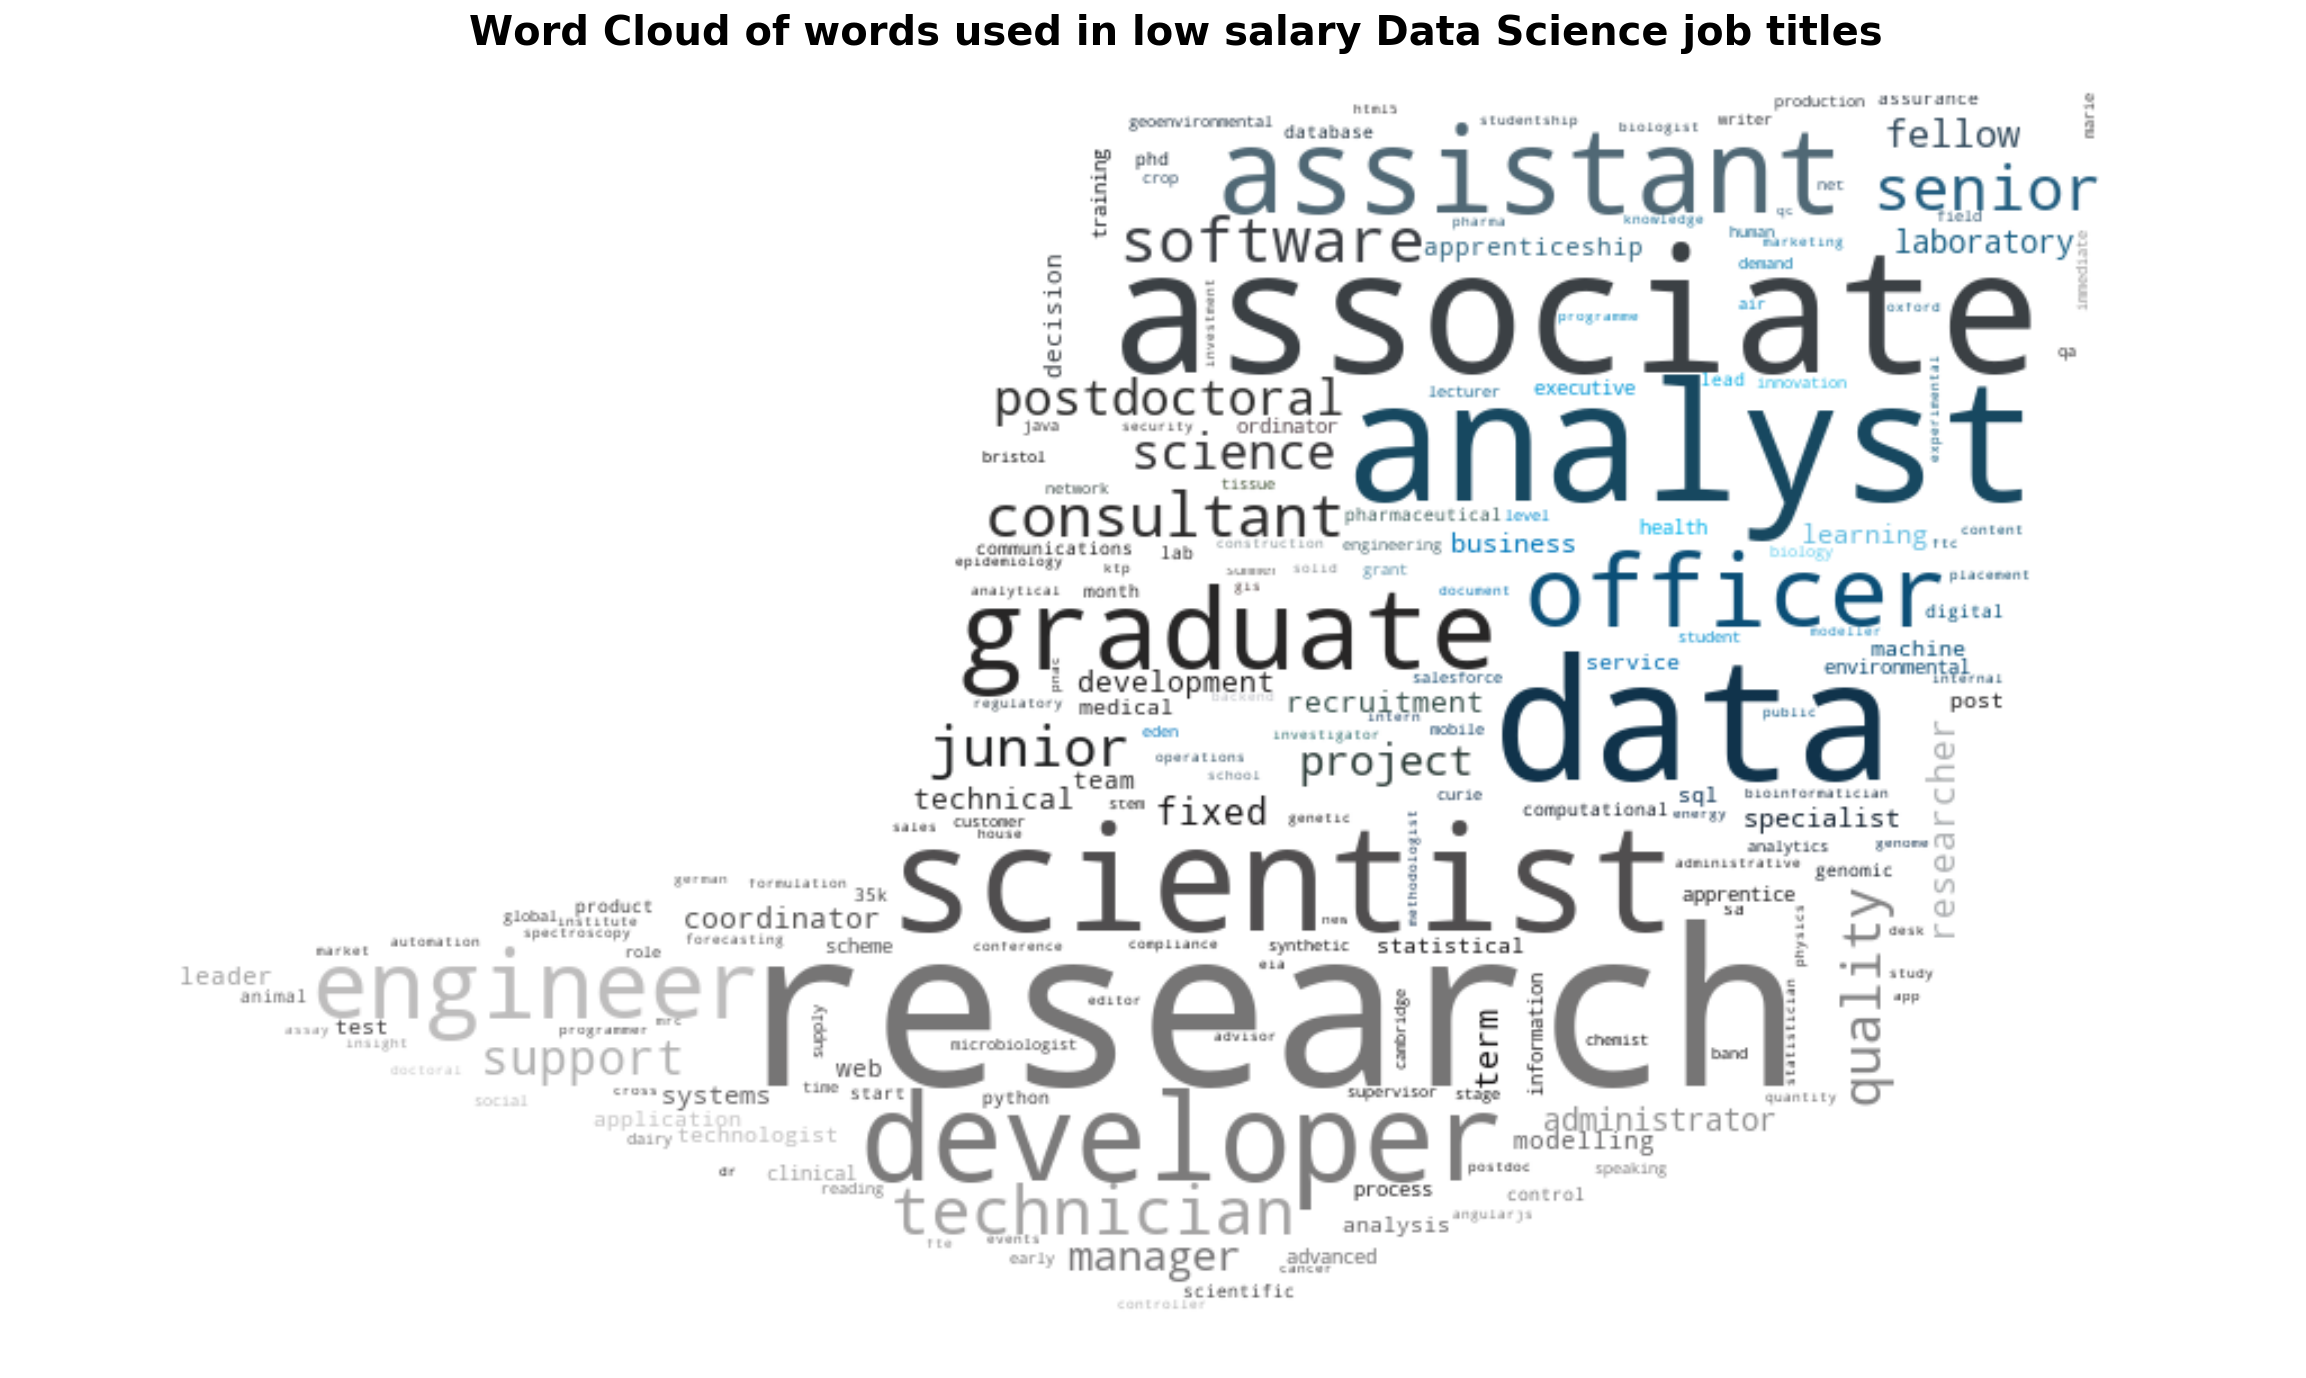

In [136]:
fig, ax = plt.subplots(figsize=(20,16))
ax.imshow(wc_low_sal.recolor(color_func=laptop_colors), interpolation='bilinear')
ax.axis("off")
ax.set_title('Word Cloud of words used in low salary Data Science job titles', fontsize=20, fontweight='bold', y=1.02)
plt.show()

Words such as associate, graduate, analyst and research come up very often in the job titles of jobs below the median salary. This makes sense as theses words would normally be associated with more entry level jobs which would be paid less.

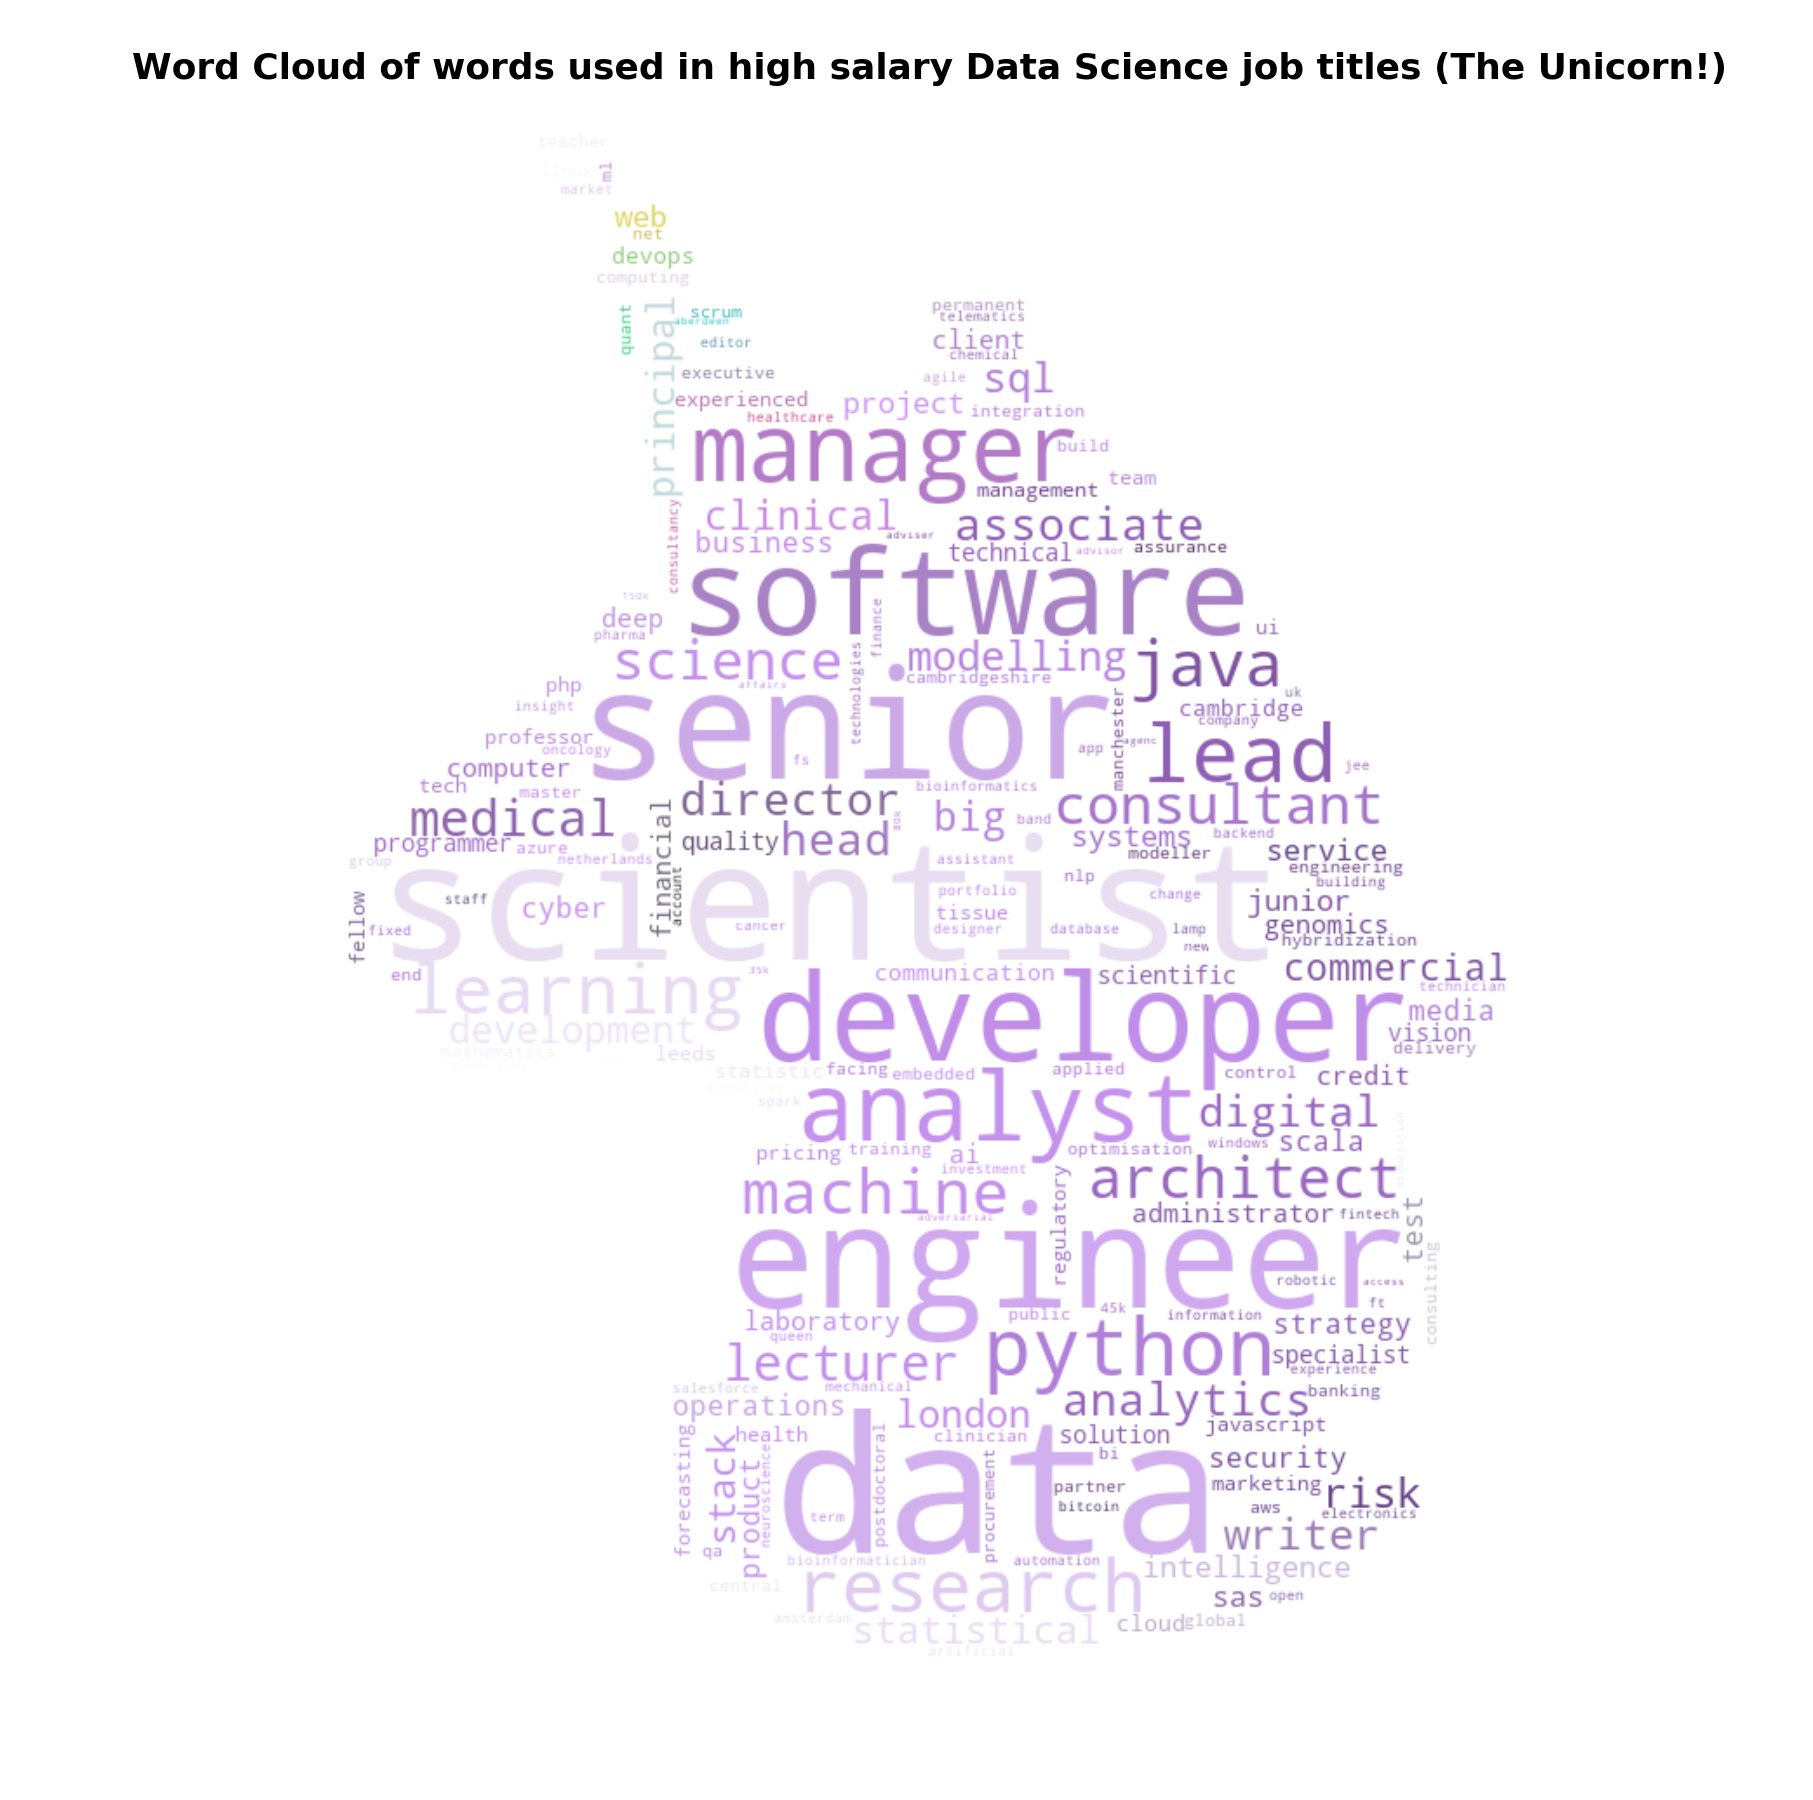

In [142]:
fig, ax = plt.subplots(figsize=(20,16))
ax.imshow(wc_high_sal.recolor(color_func=unicorn_colors), interpolation='bilinear')
ax.axis("off")
ax.set_title('Word Cloud of words used in high salary Data Science job titles (The Unicorn!)', 
             fontsize=18, fontweight='bold', y=0.96)
plt.show()

Words like senior, manager, lecturer, director and lead come up frequently in the job titles of high paid jobs. These words are more associated with senior, more well paid roles.

#####  Logistic Regression of job title CountVectorized words

In [95]:
X5 = summaries_matrix2.copy()

In [96]:
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y, test_size=0.33, stratify=y, random_state=10)

In [97]:
len(X5.columns)

871

In [98]:
ss2 = StandardScaler()
ss2.fit(X5_train)
X5_train_ss = ss2.transform(X5_train)
X5_test_ss = ss2.transform(X5_test)

In [99]:
log_reg3 = LogisticRegression(solver='liblinear')
log_reg3_hyperparams = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-5, 3, 20)
}

In [100]:
log_reg3_gs = GridSearchCV(log_reg3, log_reg3_hyperparams, cv=5, verbose=1)
log_reg3_gs.fit(X5_train_ss, y5_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   16.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-05, 2.63665e-05, 6.95193e-05, 1.83298e-04, 4.83293e-04,
       1.27427e-03, 3.35982e-03, 8.85867e-03, 2.33572e-02, 6.15848e-02,
       1.62378e-01, 4.28133e-01, 1.12884e+00, 2.97635e+00, 7.84760e+00,
       2.06914e+01, 5.45559e+01, 1.43845e+02, 3.79269e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [101]:
log_reg3_gs.best_params_

{'C': 0.4281332398719396, 'penalty': 'l1'}

In [102]:
log_reg3_gs.best_score_

0.7838235294117647

In [103]:
log_reg3_best = log_reg3_gs.best_estimator_

In [104]:
log_reg3_best.score(X5_test_ss, y5_test)

0.7880597014925373

In [105]:
log_reg3_coefs = pd.DataFrame({'1Predictor': X5.columns, 
              '2Absolute_Coefficient': abs(log_reg3_best.coef_[0]), 
              '3Coefficient': log_reg3_best.coef_[0]})
log_reg3_coefs.columns = ['Predictor', 'Absolute_Coefficient', 'Coefficient']
log_reg3_coefs.sort_values('Absolute_Coefficient', ascending=False)[:20]

,Predictor,Absolute_Coefficient,Coefficient
719,senior,0.993979,0.993979
348,graduate,0.869426,-0.869426
80,associate,0.727987,-0.727987
231,director,0.715378,0.715378
653,quality,0.618285,-0.618285
647,python,0.614767,0.614767
472,manager,0.606704,0.606704
267,engineer,0.580184,0.580184
79,assistant,0.577032,-0.577032
797,technician,0.524092,-0.524092


This is quite a good accuracy. Now Location and Industry predictors will be added in to the logistic regression.

##### Logistic regression with location and industry added in

In [106]:
X6 = X5.copy()

In [107]:
X6['Location'] = job_data['Location'].copy()
X6['Industry'] = job_data['industry'].copy()

In [108]:
X6 = pd.get_dummies(X6)

In [109]:
X6.drop(['Location_Belfast', 'Industry_Other'], axis=1, inplace=True)

In [110]:
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y, test_size=0.33, stratify=y, random_state=10)

In [111]:
ss3 = StandardScaler()
ss3.fit(X6_train)
X6_train_ss = ss3.transform(X6_train)
X6_test_ss = ss3.transform(X6_test)

In [112]:
log_reg4 = LogisticRegression(solver='liblinear')
log_reg4_hyperparams = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-5, 3, 20)
}

In [113]:
log_reg4_gs = GridSearchCV(log_reg4, log_reg4_hyperparams, cv=5, verbose=1)
log_reg4_gs.fit(X6_train_ss, y6_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   17.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-05, 2.63665e-05, 6.95193e-05, 1.83298e-04, 4.83293e-04,
       1.27427e-03, 3.35982e-03, 8.85867e-03, 2.33572e-02, 6.15848e-02,
       1.62378e-01, 4.28133e-01, 1.12884e+00, 2.97635e+00, 7.84760e+00,
       2.06914e+01, 5.45559e+01, 1.43845e+02, 3.79269e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [114]:
log_reg4_gs.best_params_

{'C': 0.023357214690901212, 'penalty': 'l2'}

In [115]:
log_reg4_gs.best_score_

0.7926470588235294

In [116]:
log_reg4_best = log_reg4_gs.best_estimator_

In [117]:
log_reg4_best.score(X6_test_ss, y6_test)

0.8238805970149253

In [179]:
log_reg4_coefs = pd.DataFrame({'1Predictor': X6.columns, 
              '2Absolute_Coefficient': abs(log_reg4_best.coef_[0]), 
              '3Coefficient': log_reg4_best.coef_[0]})
log_reg4_coefs.columns = ['Predictor', 'Absolute_Coefficient', 'Coefficient']
log_reg4_coefs_ascending = log_reg4_coefs.sort_values('Absolute_Coefficient', ascending=True)
log_reg4_coefs.sort_values('Absolute_Coefficient', ascending=False)[:20]

,Predictor,Absolute_Coefficient,Coefficient
719,senior,0.388115,0.388115
348,graduate,0.354333,-0.354333
878,Location_London,0.304783,0.304783
472,manager,0.225374,0.225374
653,quality,0.223106,-0.223106
797,technician,0.214467,-0.214467
552,officer,0.209507,-0.209507
231,director,0.205383,0.205383
647,python,0.204427,0.204427
883,Location_York,0.192474,-0.192474


In [192]:
colorstring = ''
for c in log_reg4_coefs_ascending.Coefficient[-20:]:
    if c>0:
        colorstring+='g'
    else:
        colorstring+='r'

In [193]:
colorstring

'rgrgrrrggrrggrrrggrg'

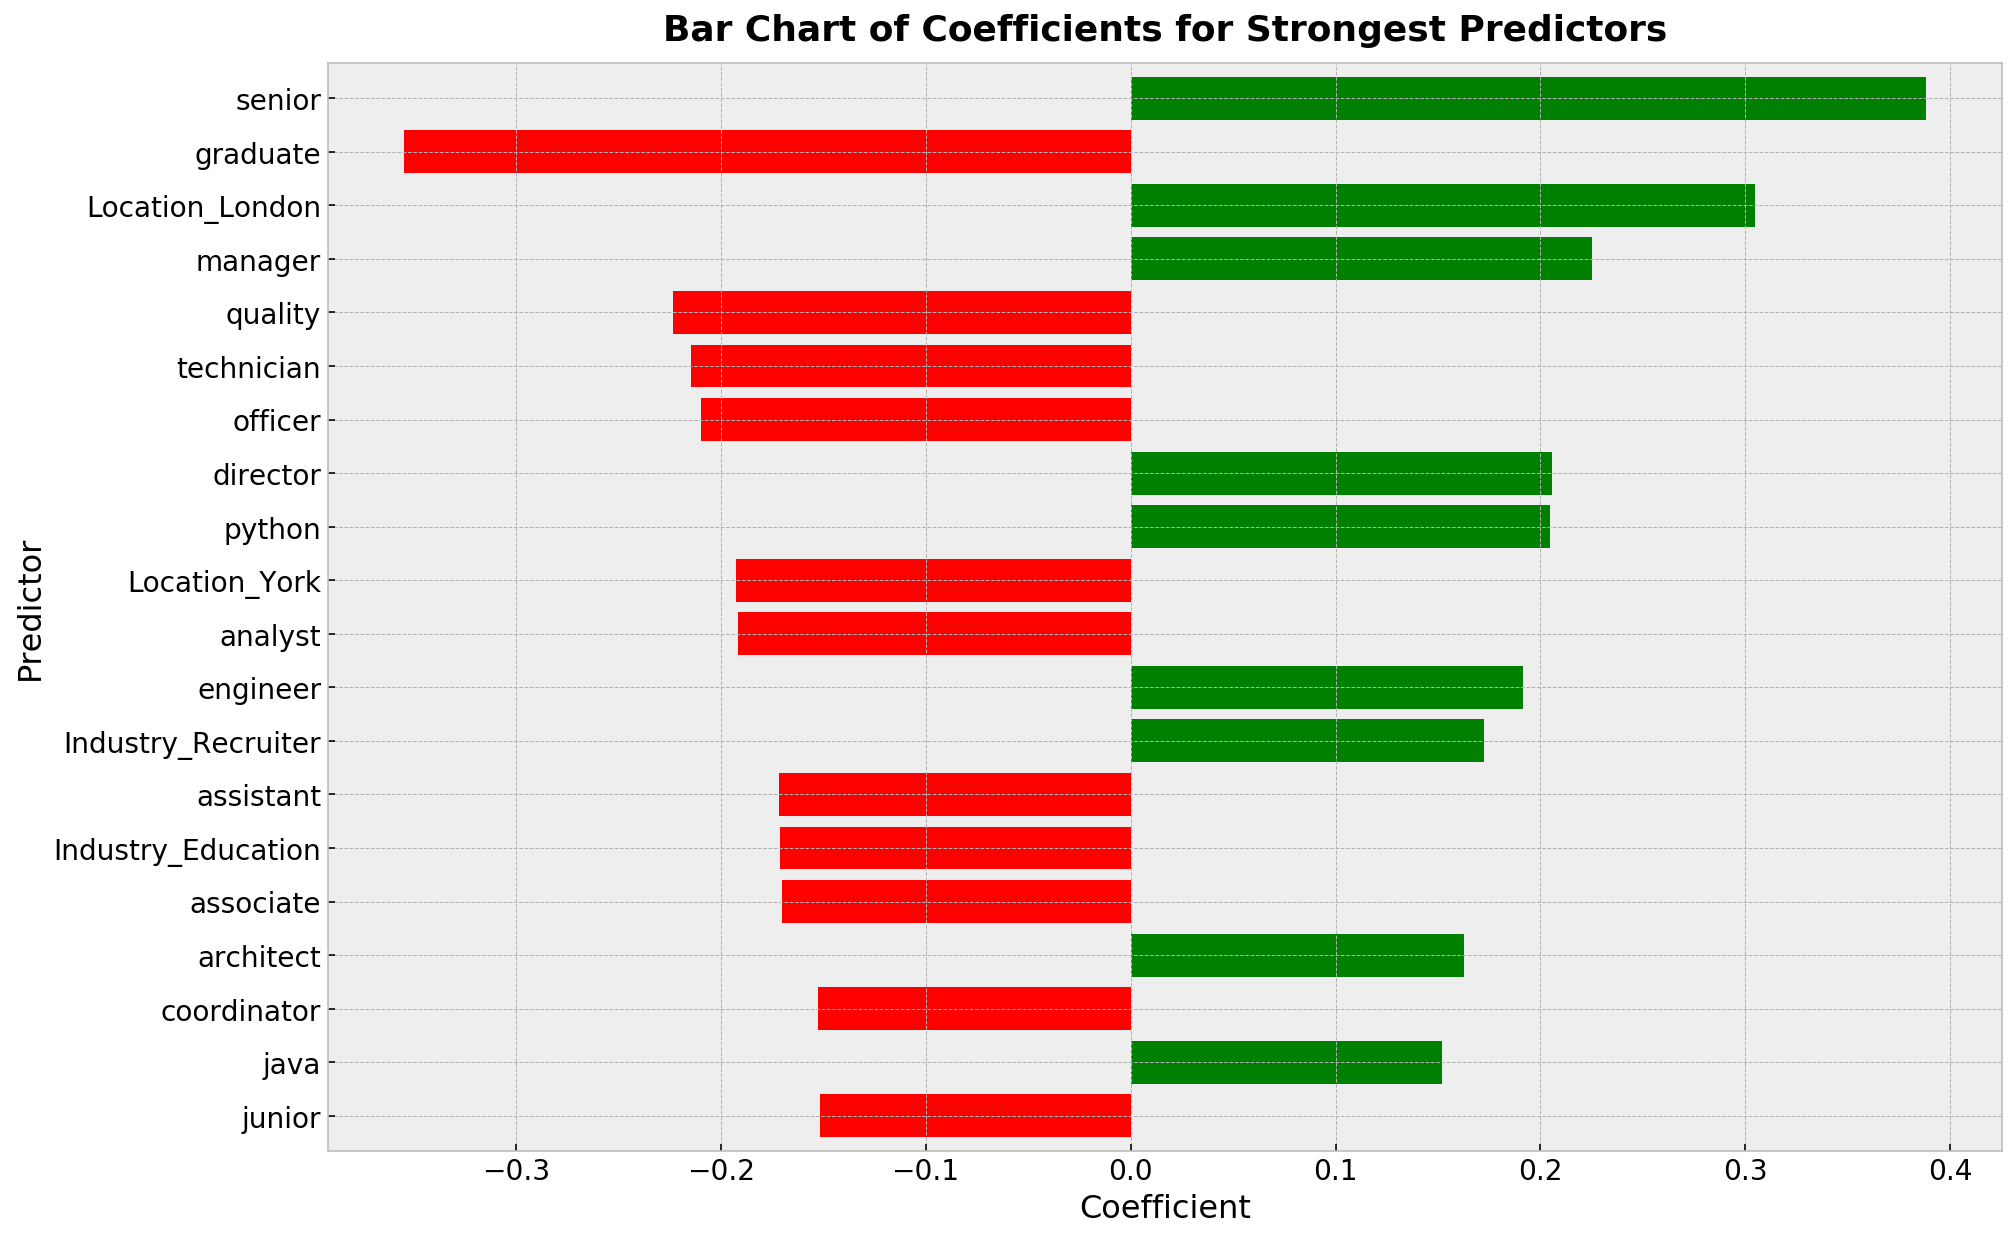

In [208]:
fig, ax = plt.subplots(figsize=(15,10))
log_reg4_coefs_ascending[-20:].plot(x='Predictor', y='Coefficient',kind='barh', 
                         color=[c for c in colorstring], width=0.8, ax=ax, legend=False)
ax.tick_params(labelsize=14)
ax.set_xlabel('Coefficient', fontsize=16)
ax.set_ylabel('Predictor', fontsize=16)
ax.set_title('Bar Chart of Coefficients for Strongest Predictors',
             fontsize=18, fontweight='bold', y=1.01)
plt.show()

A random forest model will now be used to see if any improvement can be made on the logistic regression.

##### Random forest

In [125]:
random_forest = RandomForestClassifier(n_estimators=300)
random_forest_hyperparams = {
    'max_features': [5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, None],
    'max_depth': [2, 3, 4, 5, 10, 20, 30, 40, None]
}

In [126]:
random_forest_gs = GridSearchCV(random_forest, random_forest_hyperparams, cv=5, verbose=1)
random_forest_gs.fit(X6_train_ss, y6_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=1)]: Done 630 out of 630 | elapsed:  7.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, None], 'max_depth': [2, 3, 4, 5, 10, 20, 30, 40, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [127]:
random_forest_gs.best_params_

{'max_depth': 30, 'max_features': 20}

In [128]:
random_forest_gs.best_score_

0.8014705882352942

In [129]:
random_forest_best = random_forest_gs.best_estimator_

In [130]:
random_forest_best.score(X6_test_ss, y6_test)

0.8328358208955224

In [161]:
random_forest_feature_importances = pd.DataFrame({'1Predictor': X6.columns, 
              '2Absolute_Coefficient': random_forest_best.feature_importances_})
random_forest_feature_importances.columns = ['Predictor', 'Feature_Importance']
top_20 = random_forest_feature_importances.sort_values('Feature_Importance', ascending=False)[:20]
top_20

,Predictor,Feature_Importance
878,Location_London,0.044321
719,senior,0.041557
348,graduate,0.040473
207,data,0.028776
885,Industry_Education,0.026620
887,Industry_Recruiter,0.026493
677,research,0.020417
267,engineer,0.020099
707,scientist,0.019394
552,officer,0.018026


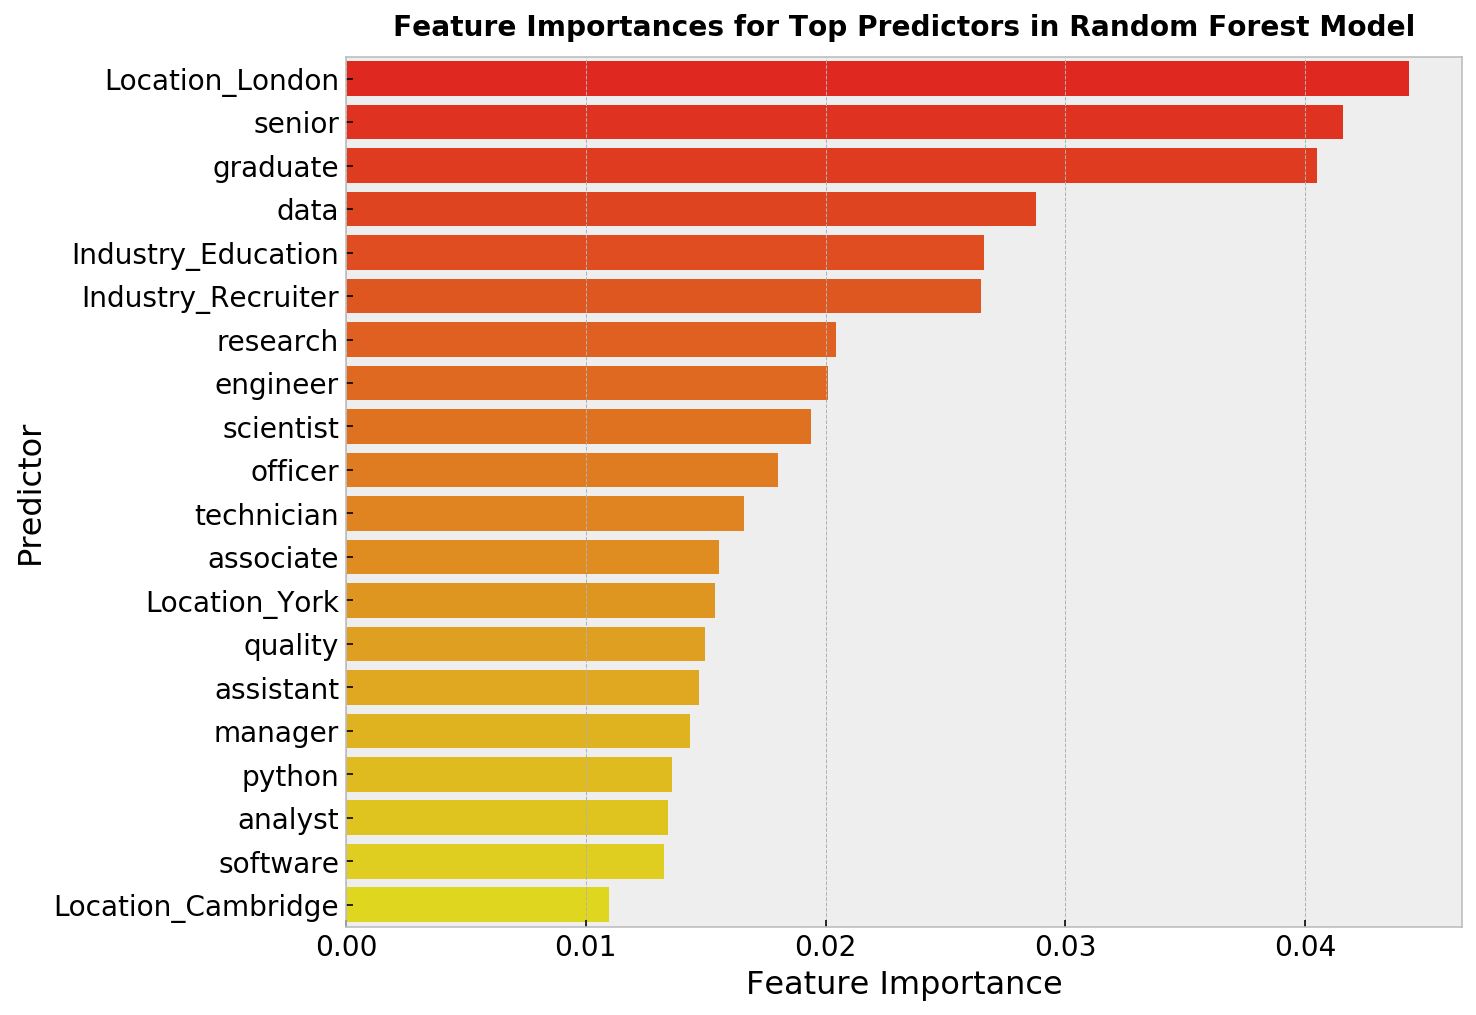

In [211]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Feature_Importance', y='Predictor', data=top_20, palette='autumn', ax=ax)
ax.tick_params(labelsize=14)
ax.set_xlabel('Feature Importance', fontsize=16)
ax.set_ylabel('Predictor', fontsize=16)
ax.set_title('Feature Importances for Top Predictors in Random Forest Model', fontsize=14, fontweight='bold', y=1.01)
plt.show()

#### Model evaluation

##### Logistic regression on location only

In [256]:
confusion = confusion_matrix(y1_test, log_reg_best.predict(X1_test), labels=[0,1])

In [257]:
pd.DataFrame(confusion, columns=['Predicted_Low_Salary', 'Predicted_High_Salary'], 
             index=['Actual_Low_Salary', 'Actual_High_Salary'])

,Predicted_Low_Salary,Predicted_High_Salary
Actual_Low_Salary,83,80
Actual_High_Salary,48,124


In [258]:
print(classification_report(y1_test, log_reg_best.predict(X1_test)))

             precision    recall  f1-score   support

          0       0.63      0.51      0.56       163
          1       0.61      0.72      0.66       172

avg / total       0.62      0.62      0.61       335



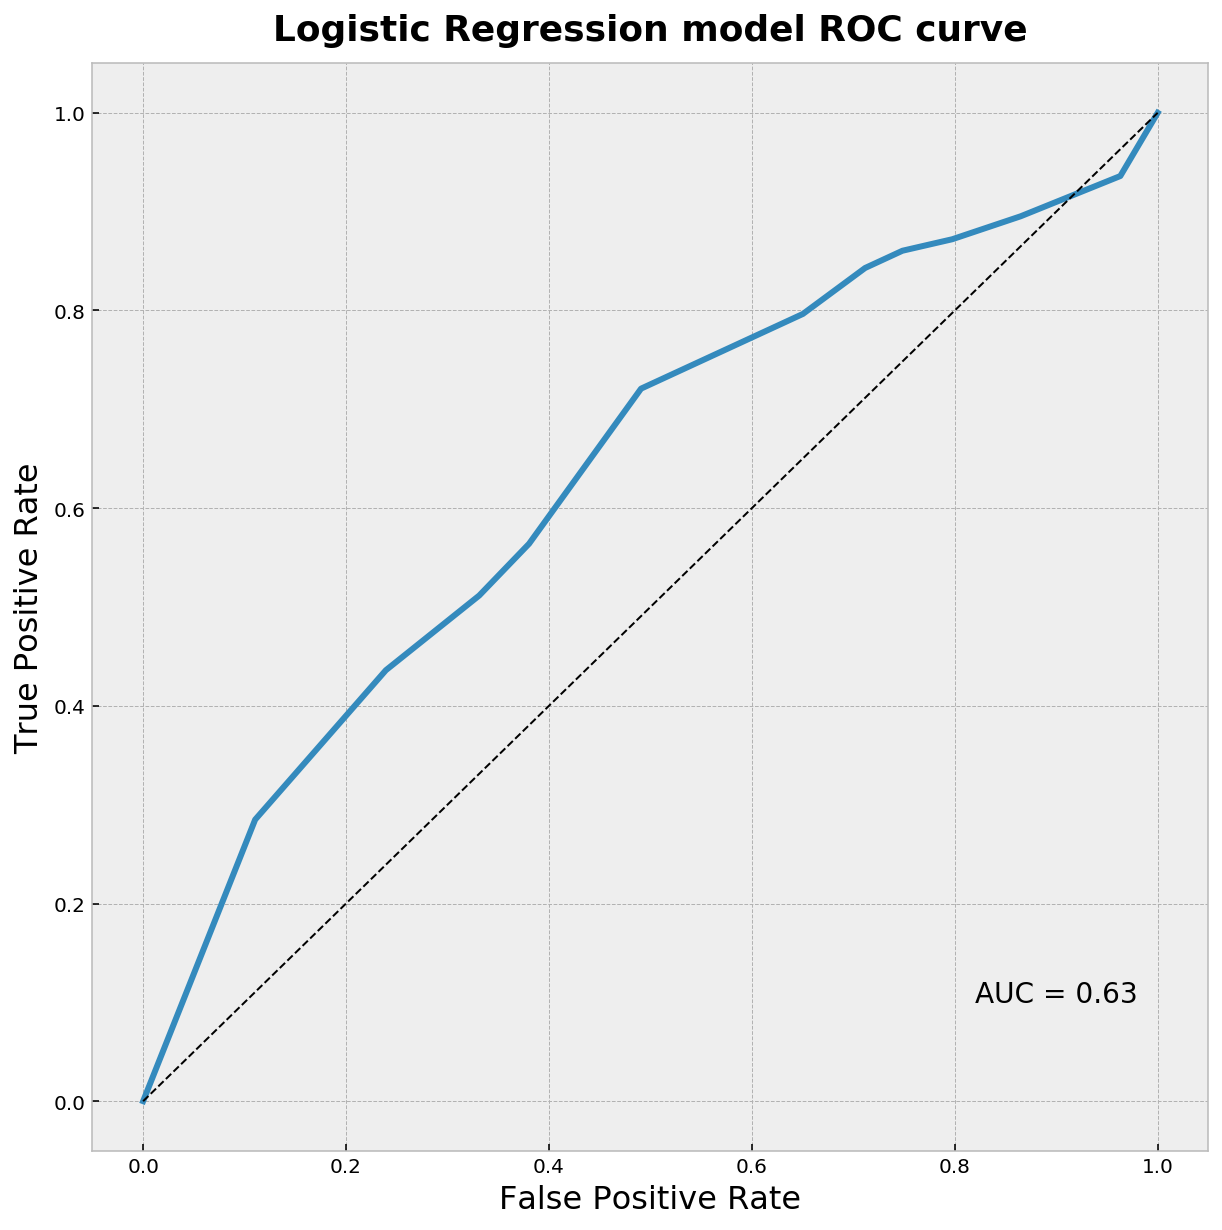

In [260]:
probabilities = pd.DataFrame(log_reg_best.predict_proba(X1_test), 
                             columns=['predict_low_salary','predict_high_salary'])
fpr, tpr, thresholds = roc_curve(y1_test,probabilities.predict_high_salary)
auc_score = roc_auc_score(y1_test, probabilities.predict_high_salary)
plt.figure(figsize=[10,10])
plt.plot(fpr,tpr,linewidth=3)
plt.plot([0,1],[0,1], c='black', lw=1, ls='dashed')
plt.title('Logistic Regression model ROC curve', y=1.01, fontsize=18, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate(s='AUC = '+str(auc_score.round(2)), xy=(0.82,0.1), fontsize=14)
plt.show()

##### Logistic regression on CountVectorized job titles, industries and locations

In [261]:
confusion2 = confusion_matrix(y6_test, log_reg4_best.predict(X6_test_ss), labels=[0,1])

In [262]:
pd.DataFrame(confusion2, columns=['Predicted_Low_Salary', 'Predicted_High_Salary'], 
             index=['Actual_Low_Salary', 'Actual_High_Salary'])

,Predicted_Low_Salary,Predicted_High_Salary
Actual_Low_Salary,128,35
Actual_High_Salary,24,148


In [263]:
print(classification_report(y6_test, log_reg4_best.predict(X6_test_ss)))

             precision    recall  f1-score   support

          0       0.84      0.79      0.81       163
          1       0.81      0.86      0.83       172

avg / total       0.82      0.82      0.82       335



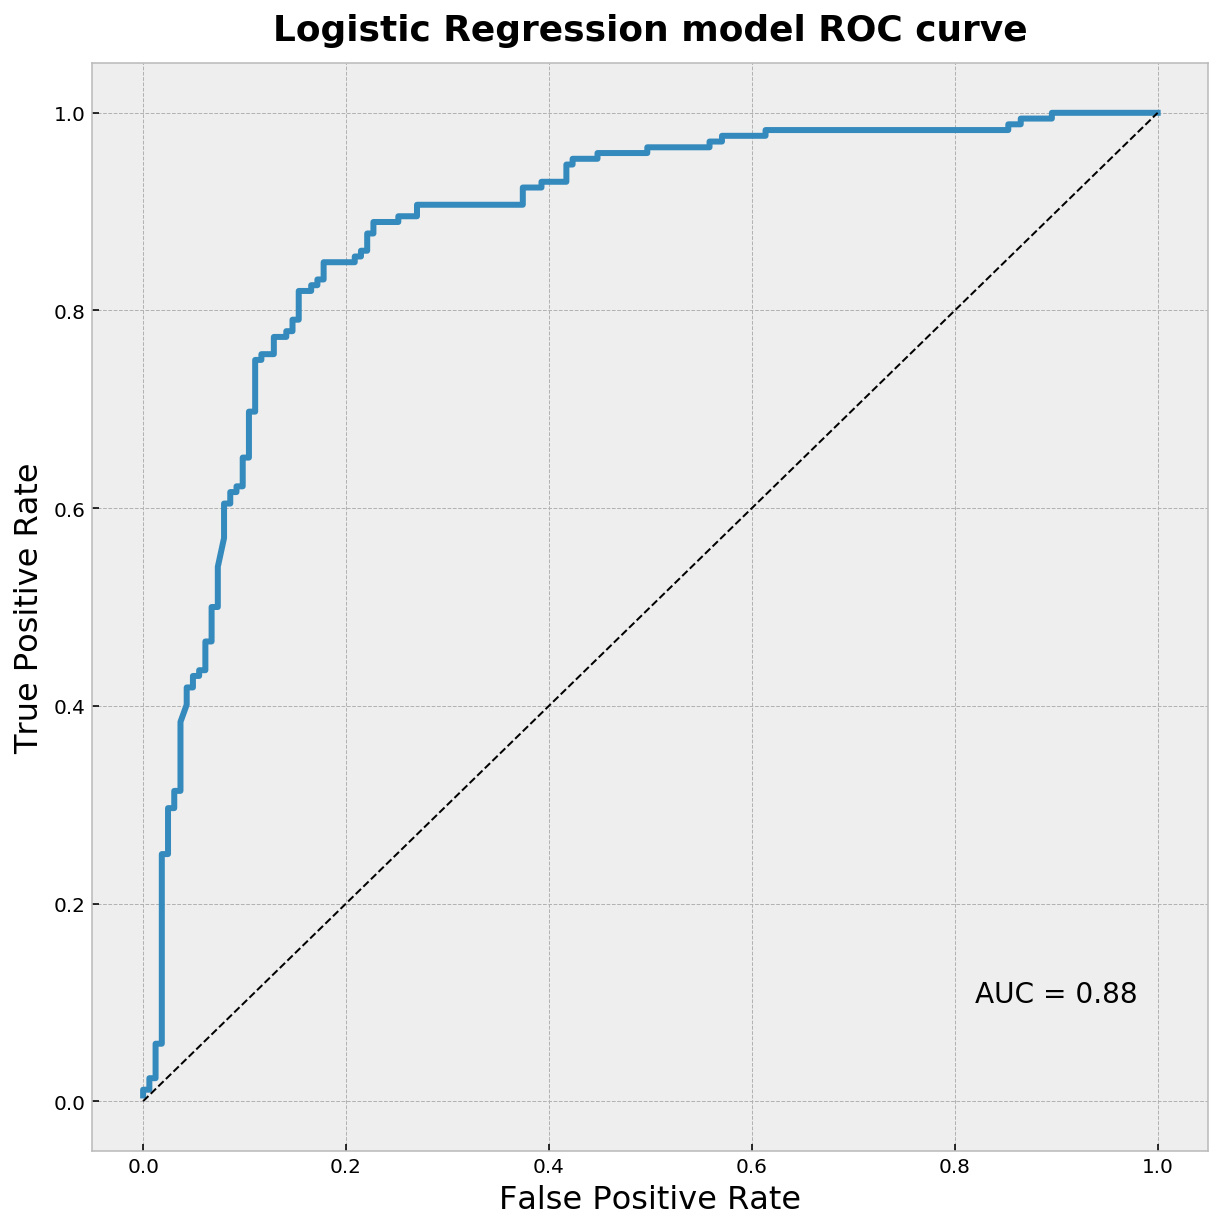

In [264]:
probabilities = pd.DataFrame(log_reg4_best.predict_proba(X6_test_ss), 
                             columns=['predict_low_salary','predict_high_salary'])
fpr, tpr, thresholds = roc_curve(y6_test,probabilities.predict_high_salary)
auc_score = roc_auc_score(y6_test, probabilities.predict_high_salary)
plt.figure(figsize=[10,10])
plt.plot(fpr,tpr,linewidth=3)
plt.plot([0,1],[0,1], c='black', lw=1, ls='dashed')
plt.title('Logistic Regression model ROC curve', y=1.01, fontsize=18, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate(s='AUC = '+str(auc_score.round(2)), xy=(0.82,0.1), fontsize=14)
plt.show()

##### Random Forest on CountVectorized job titles

In [153]:
confusion3 = confusion_matrix(y6_test, random_forest_best.predict(X6_test_ss), labels=[0,1])

In [154]:
pd.DataFrame(confusion3, columns=['Predicted_Low_Salary', 'Predicted_High_Salary'], 
             index=['Actual_Low_Salary', 'Actual_High_Salary'])

,Predicted_Low_Salary,Predicted_High_Salary
Actual_Low_Salary,127,36
Actual_High_Salary,20,152


In [155]:
print(classification_report(y6_test, random_forest_best.predict(X6_test_ss)))

             precision    recall  f1-score   support

          0       0.86      0.78      0.82       163
          1       0.81      0.88      0.84       172

avg / total       0.84      0.83      0.83       335



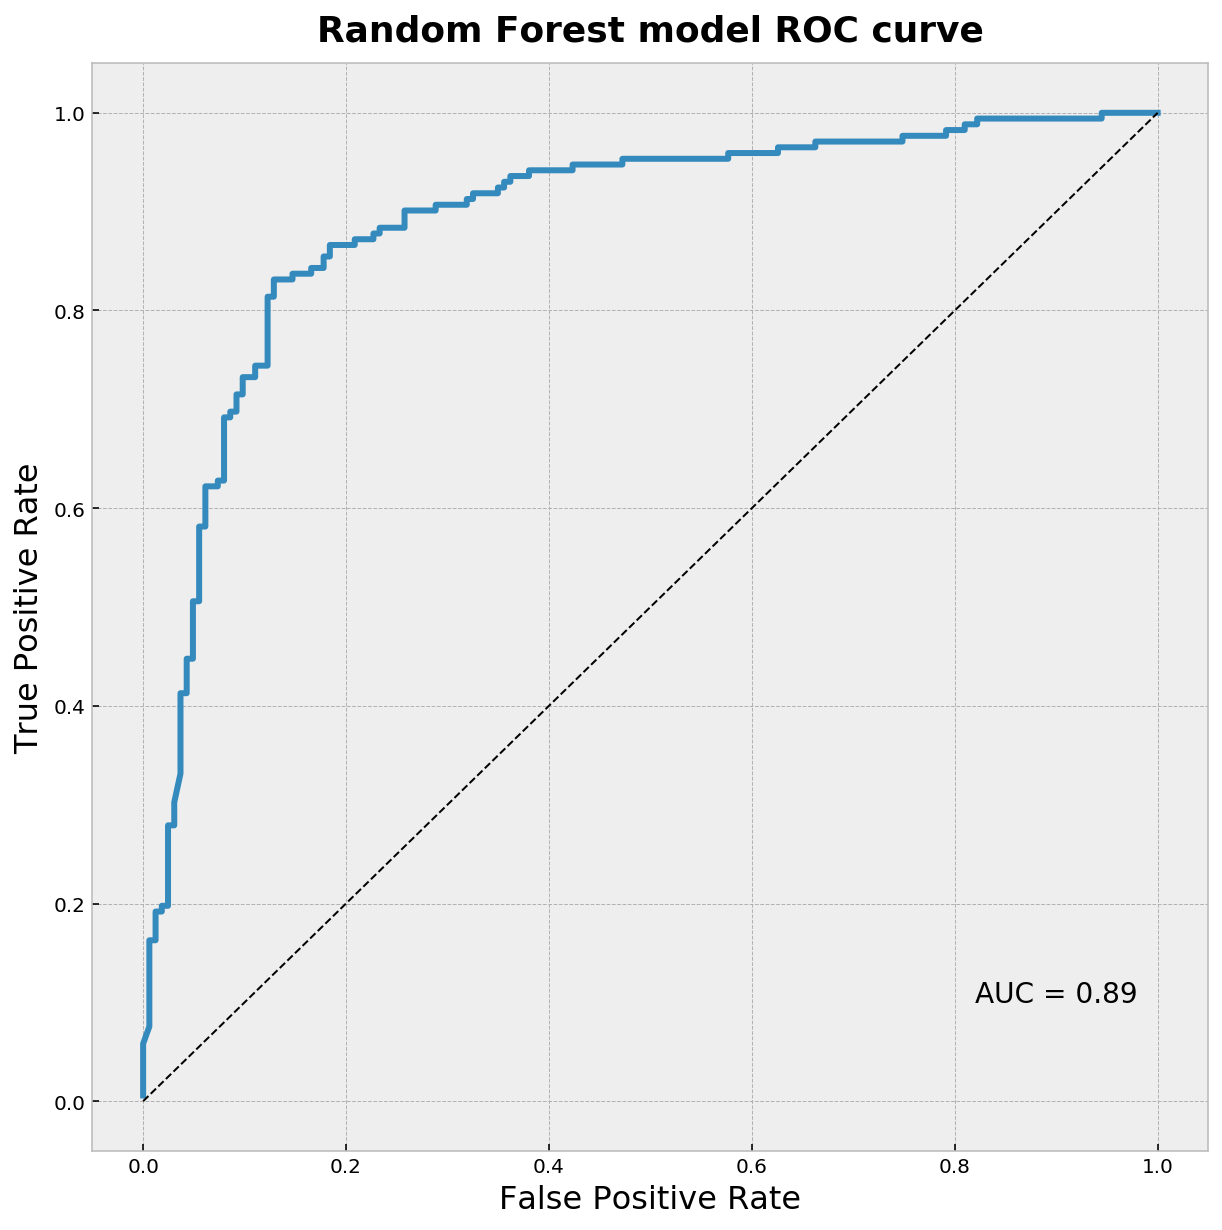

In [134]:
probabilities = pd.DataFrame(random_forest_best.predict_proba(X6_test_ss), 
                             columns=['predict_low_salary','predict_high_salary'])
fpr, tpr, thresholds = roc_curve(y6_test,probabilities.predict_high_salary)
auc_score = roc_auc_score(y6_test, probabilities.predict_high_salary)
plt.figure(figsize=[10,10])
plt.plot(fpr,tpr,linewidth=3)
plt.plot([0,1],[0,1], c='black', lw=1, ls='dashed')
plt.title('Random Forest model ROC curve', y=1.01, fontsize=18, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate(s='AUC = '+str(auc_score.round(2)), xy=(0.82,0.1), fontsize=14)
plt.show()

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

https://www.angusfranz.com/single-post/2018/04/26/Classifying-Data-Science-job-adverts

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

https://www.angusfranz.com/single-post/2018/04/26/Classifying-Data-Science-job-adverts